### Model building:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

### Read in saved data:

In [3]:
df = pd.read_pickle("interim_data/jan_subset_v2")

In [4]:
#convert FL_DATE to datetime object
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

In [5]:
#count incoming flights per destination airport per day
df["dest_fl"] = df.groupby(["FL_DATE", "DEST_AIRPORT_ID"])["ARR_DEL15"].transform("count")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565963 entries, 0 to 583984
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   MONTH              565963 non-null  int64         
 1   DAY                565963 non-null  int64         
 2   DAY_OF_WEEK        565963 non-null  int64         
 3   FL_DATE            565963 non-null  datetime64[ns]
 4   AIRLINE_ID         565963 non-null  int64         
 5   FLIGHT_NUM         565963 non-null  int64         
 6   ORIGIN_AIRPORT_ID  565963 non-null  int64         
 7   ORIGIN_CITY        565963 non-null  object        
 8   ORIGIN_STATE       565963 non-null  object        
 9   DEST_AIRPORT_ID    565963 non-null  int64         
 10  DEST_CITY          565963 non-null  object        
 11  DEST_STATE         565963 non-null  object        
 12  CRS_DEP_TIME       565963 non-null  int64         
 13  CRS_ARR_TIME       565963 non-null  int64   

In [7]:
df.groupby(["DAY_OF_WEEK"])["ARR_DEL15"].count()

DAY_OF_WEEK
1    76805
2    89682
3    93343
4    96473
5    78654
6    60146
7    70860
Name: ARR_DEL15, dtype: int64

### Reduce ARR_TIME, ORIGIN_STATE, and DEST_STATE categories for modeling later:

In [8]:
df["arr_time_2hrs"] = df.loc[:, ["ARR_TIME_HR"]]//2
#df.groupby(["ARR_TIME_HR"])["ARR_DEL15"].count()
#df.groupby(["arr_time_2hrs"])["ARR_DEL15"].count()

In [10]:
#combining DEST_STATE into regions
#read in the regions data and merge the data sets
regions = pd.read_csv("US_CENSUS_BUREAU_REGIONS.csv")
regions.drop(columns = ["State", "Division"], axis = 1, inplace = True)

df = df.merge(regions, how = "left", left_on = "DEST_STATE", right_on = "State Code")

df["Region"].fillna("Other", inplace = True)
df.rename(columns = {"Region":"dest_region"}, inplace = True)
df.drop(["State Code"], axis = 1, inplace = True)

In [11]:
#combining ORIGIN_STATE into regions
df = df.merge(regions, how = "left", left_on = "ORIGIN_STATE", right_on = "State Code")

df["Region"].fillna("Other", inplace = True)
df.rename(columns = {"Region":"origin_region"}, inplace = True)
df.drop(["State Code"], axis = 1, inplace = True)

### Pairplot to examine features-target relationship

In [12]:
def plot_features(feature, sample_size = 2000):
    sample = df[feature].sample(sample_size, random_state = 44)
    g = sns.pairplot(sample, hue = "ARR_DEL15", plot_kws = dict(alpha = 0.2, edgecolor = "none"))

In [14]:
plot_features(["AIR_TIME", "DISTANCE", "dest_fl", "ARR_DEL15"])

In [15]:
plot_features(["DAY", "DAY_OF_WEEK", "AIRLINE_ID", "FLIGHT_NUM", "ARR_DEL15"])

### ^^what does it mean for airlines to have multiple peaks? None of the features seem to have good separation T.T...

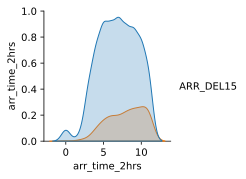

In [16]:
plot_features(["arr_time_2hrs", "ARR_DEL15"])

### Create X (feature matrix) and y (target):

In [33]:
X = df.loc[:,["AIR_TIME", "DISTANCE"]]
y = df["ARR_DEL15"]

In [18]:
# perform train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 11)

### Check class balance, 0.81 vs 0.19, consistent in test set too:

0    0.813603
1    0.186397
Name: ARR_DEL15, dtype: float64


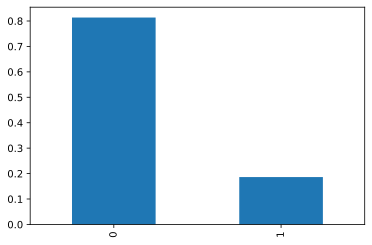

In [19]:
arr_delay = y_train.value_counts(normalize = True)
print(arr_delay)
arr_delay.plot(kind = "bar");

In [20]:
arr_delay = y_val.value_counts(normalize = True)
print(arr_delay)
#arr_delay.plot(kind = "bar");

0    0.816005
1    0.183995
Name: ARR_DEL15, dtype: float64


### Build a baseline logistic regression model with the 2 continuous variables:

In [21]:
def logistic_regression(X_train, y_train, X_val, y_val):
    # fit logistic regression to training data
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = f1_score(lr.predict(X_val), y_val)
    results = classification_report(y_val, lr.predict(X_val), \
                                    target_names = ["On Time", "Delay"])
                                    
    # print results
    print("\nValidation f1 score was:", val_score, "\nResults:", results)
    return lr

In [22]:
lr = logistic_regression(X_train, y_train, X_val, y_val)


Validation f1 score was: 0.0011516867412063921 
Results:               precision    recall  f1-score   support

     On Time       0.82      1.00      0.90     92366
       Delay       1.00      0.00      0.00     20827

    accuracy                           0.82    113193
   macro avg       0.91      0.50      0.45    113193
weighted avg       0.85      0.82      0.73    113193



### Create confusion matrix (contingency table between actual vs prediction):

In [56]:
def make_confusion_matrix(model, threshold = 0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    delay_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi = 200)
    sns.set(font_scale = 1.5)
    sns.heatmap(delay_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=["On Time", "Delay"],
           yticklabels=["On Time", "Delay"]);
    plt.xlabel("Prediction", weight = "bold")
    plt.ylabel("Actual", weight = "bold")
    plt.title("Logistic Regression Confusion Matrix")
    plt.tight_layout();

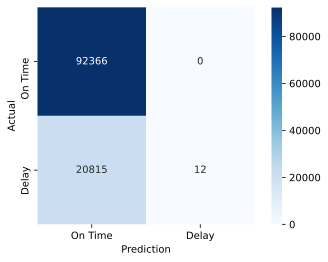

In [24]:
make_confusion_matrix(lr, threshold = 0.5)
#plt.savefig("delay_mat.png");

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [27]:
#add airlines as a dummy variable to the features
alines = df.loc[:, ["AIRLINE_ID"]]

ohe = OneHotEncoder(drop = "first", sparse = False)
ohe.fit(alines)
ohe_alines = ohe.transform(alines)
columns = ohe.get_feature_names(["AIRLINE_ID"])
alines_df = pd.DataFrame(ohe_alines, columns = columns, index = alines.index)
print(alines_df.shape)

(565963, 16)


In [31]:
#add destination region as a dummy variable to the model
regions = df.loc[:, ["dest_region"]]

ohe = OneHotEncoder(drop = "first", sparse = False)
ohe.fit(regions)
ohe_regions = ohe.transform(regions)
columns = ohe.get_feature_names(["dest_region"])
regions_df = pd.DataFrame(ohe_regions, columns = columns, index = regions.index)

In [32]:
#add origin region as a dummy variable to the model
ori_regions = df.loc[:, ["origin_region"]]

ohe = OneHotEncoder(drop = "first", sparse = False)
ohe.fit(ori_regions)
ohe_ori_regions = ohe.transform(ori_regions)
columns = ohe.get_feature_names(["origin_region"])
ori_regions_df = pd.DataFrame(ohe_ori_regions, columns = columns, index = ori_regions.index)

### Feature Engineering: interactions between arr time in the day and dest_fl

In [34]:
X2 = df.loc[:,["AIR_TIME", "DISTANCE", "arr_time_2hrs", "DAY_OF_WEEK", "dest_fl"]]
X2["interaction"] = X2["arr_time_2hrs"]*X2["dest_fl"]

In [35]:
X2 = pd.concat([X2, alines_df, regions_df, ori_regions_df], axis = 1)

In [36]:
X2.shape

(565963, 30)

### ^^f1 score goes up to 0.011 with logistic regression <br> Let's try Random Forests:

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
#define function to standardize features
def standardize(X_train, X_val):
    std = StandardScaler()
    std.fit(X_train.values)

    X_tr = std.transform(X_train.values)
    X_va = std.transform(X_val.values)
    
    return(X_tr, X_va)

In [30]:
def random_forests(X_tr, y_train, X_va, y_val):
    #fit a RandomForestClassifier on training data
    RF = RandomForestClassifier(n_estimators = 100, max_features = 10)
    RF.fit(X_tr, y_train)
    #make prediction on validation data and print results
    y_pred = RF.predict(X_va)
    RF_result = classification_report(y_val, y_pred, target_names = ["On Time", "Delay"])
    print("\nResults:", RF_result)
    
    return RF

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X2, y, test_size = 0.2, random_state = 11)

In [39]:
X_tr, X_va = standardize(X_train, X_val)

In [40]:
rf_spe = random_forests(X_tr, y_train, X_va, y_val)


Results:               precision    recall  f1-score   support

     On Time       0.85      0.95      0.89     92366
       Delay       0.51      0.23      0.32     20827

    accuracy                           0.82    113193
   macro avg       0.68      0.59      0.61    113193
weighted avg       0.78      0.82      0.79    113193



In [62]:
for i in np.linspace(0.1, 0.45, 8):
    predicted_proba = rf_spe.predict_proba(X_va)
    y_pred = (predicted_proba[:,1] >= i).astype("int")
    result = classification_report(y_val, y_pred, \
                                    target_names = ["On Time", "Delay"])
    print(f"\nResults for {i}:", result)


Results:               precision    recall  f1-score   support

     On Time       0.91      0.47      0.62     92366
       Delay       0.25      0.79      0.38     20827

    accuracy                           0.53    113193
   macro avg       0.58      0.63      0.50    113193
weighted avg       0.79      0.53      0.57    113193


Results:               precision    recall  f1-score   support

     On Time       0.90      0.60      0.72     92366
       Delay       0.28      0.69      0.40     20827

    accuracy                           0.62    113193
   macro avg       0.59      0.65      0.56    113193
weighted avg       0.78      0.62      0.66    113193


Results:               precision    recall  f1-score   support

     On Time       0.89      0.70      0.78     92366
       Delay       0.31      0.60      0.41     20827

    accuracy                           0.68    113193
   macro avg       0.60      0.65      0.60    113193
weighted avg       0.78      0.68      0.71 

In [63]:
#save RF model
import os, pickle
if not os.path.exists('models'):
    os.makedirs('models')
    
with open("models/RF_X2.pickle", "wb") as pfile:
         pickle.dump(rf_spe, pfile)

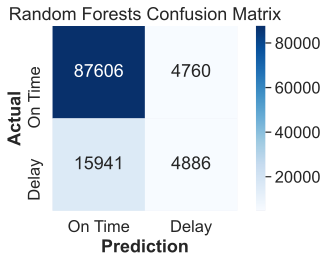

In [49]:
y_pred = rf_spe.predict(X_va) 
delay_confusion = confusion_matrix(y_val, y_pred)
plt.figure(dpi = 200)
sns.set(font_scale = 1.5)
sns.heatmap(delay_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=["On Time", "Delay"],
       yticklabels=["On Time", "Delay"]);
plt.xlabel("Prediction", weight = "bold")
plt.ylabel("Actual", weight = "bold")
plt.title("Random Forests Confusion Matrix")
plt.tight_layout();
#plt.savefig("Random Forests final confusion matrix.svg");

In [50]:
lr_comparison = logistic_regression(X_tr, y_train, X_va, y_val)


Validation f1 score was: 0.037186212064443606 
Results:               precision    recall  f1-score   support

     On Time       0.82      1.00      0.90     92366
       Delay       0.76      0.02      0.04     20827

    accuracy                           0.82    113193
   macro avg       0.79      0.51      0.47    113193
weighted avg       0.81      0.82      0.74    113193



In [64]:
with open("models/LR_X2.pickle", "wb") as pfile:
         pickle.dump(lr_comparison, pfile)

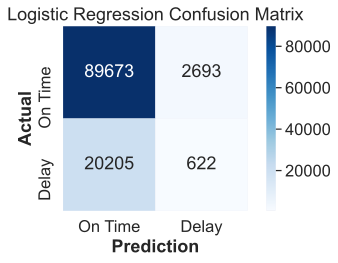

In [57]:
make_confusion_matrix(lr_comparison, threshold = 0.5)
plt.savefig("Logistic Regression confusion matrix.svg")

### Trying out Ensemble: not working as well as Random Froests

In [65]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [67]:
# Load pre-trained/tuned models
model_names = ["RF_X2", "LR_X2"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [68]:
voting_classifer = VotingClassifier(estimators = model_list,
                                    voting = "hard",
                                    n_jobs = -1)
voting_classifer.fit(X_tr, y_train)

VotingClassifier(estimators=[('RF_X2', RandomForestClassifier(max_features=10)),
                             ('LR_X2', LogisticRegression())],
                 n_jobs=-1)

In [69]:
y_pred = voting_classifer.predict(X_va)

vc_result = classification_report(y_val, y_pred, target_names = ["On Time", "Delay"])
print("\nResults:", vc_result)


Results:               precision    recall  f1-score   support

     On Time       0.82      1.00      0.90     92366
       Delay       0.87      0.01      0.03     20827

    accuracy                           0.82    113193
   macro avg       0.85      0.51      0.46    113193
weighted avg       0.83      0.82      0.74    113193



### Interesting feature engineering concept, cyclical time and day of week : too bad doesn't really work

In [ ]:
df['time_sin'] = np.sin(df["ARR_TIME_HR"]*(2.*np.pi/24))
df['time_cos'] = np.cos(df["ARR_TIME_HR"]*(2.*np.pi/24))
df['dow_sin'] = np.sin((df["DAY_OF_WEEK"]-1)*(2.*np.pi/7))
df['dow_cos'] = np.cos((df["DAY_OF_WEEK"]-1)*(2.*np.pi/7))

In [ ]:
df.columns

In [ ]:
X = df.loc[:,["AIR_TIME", "DISTANCE", "time_sin", "time_cos", "dow_sin", "dow_cos", "dest_fl"]]
y = df["ARR_DEL15"]

In [ ]:
X_time = pd.concat([X, alines_df, regions_df, ori_regions_df], axis = 1)

In [ ]:
X_time.shape

In [ ]:
X_time["interact1"] = X_time["time_sin"]*X_time["dest_fl"]
X_time["interact2"] = X_time["time_cos"]*X_time["dest_fl"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_time, y, test_size = 0.2, random_state = 11)

In [ ]:
X_tr, X_va = standardize(X_train, X_val)

In [ ]:
rf_time = random_forests(X_tr, y_train, X_va, y_val)